In [0]:
import gym
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
import torch.nn as nn
import torch.optim as optim

In [0]:
env = gym.make('CartPole-v1')

In [0]:
print(env.observation_space)
print(env.action_space)

Box(4,)
Discrete(2)


## Random Agent Baseline

In [0]:
episodes = 1000
returns = []
steps = []
for i in range(episodes):

    total_reward = 0
    step = 0
    state = env.reset()
    done = False
    while not done:
        state, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
        step += 1
#     print('total reward', total_reward)
#     print('steps', step)
    returns.append(total_reward)
    steps.append(step)
    
print(np.mean(returns), np.std(returns))
print(np.mean(steps), np.std(steps))

22.016 11.232174500068986
22.016 11.232174500068986


## REINFORCE (Vanilla Policy Gradient)

In [0]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
policy = nn.Sequential(
    nn.Linear(4, 2),
    nn.Softmax(dim=0)
)
policy.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
  (1): Softmax()
)

In [0]:
optimizer = optim.SGD(policy.parameters(), lr=2**(-13))

In [0]:
gamma = 0.99
episodes = 10000
returns = []
steps = []
for i in tqdm(range(episodes)):

    total_reward = 0
    step = 0
    state = env.reset()
    done = False
    
    memory = []
    episode_rewards = []
    while not done:
        # get probabilities of doing each action
        with torch.no_grad():
            action_probabilities = policy(torch.from_numpy(state.astype('float32')).to(device))
        # https://pytorch.org/docs/stable/distributions.html
        dist = torch.distributions.Categorical(action_probabilities)
        action = dist.sample()
            
        next_state, reward, done, info = env.step(action.cpu().numpy())
        episode_rewards.append(reward)
        
        memory.append((state, action, reward, next_state))
        
        step += 1
        state = next_state
    # number of steps (terminal step)
    T = step
    discounting = gamma ** np.arange(T)
    for t, memory_t in enumerate(memory):
        state, action, reward, next_state = memory_t
        
        # compute with gradients
        policy.zero_grad()
        action_probabilities = policy(torch.from_numpy(state.astype('float32')).to(device))
        dist = torch.distributions.Categorical(action_probabilities)
        
        G = np.sum(discounting[:T-t] * episode_rewards[t:])
        
        loss = -dist.log_prob(action) * gamma**t * G
        
        loss.backward()
        optimizer.step()
        
        
        
    returns.append(np.sum(episode_rewards))
    steps.append(step)
    
print(np.mean(returns), np.std(returns))
print(np.mean(steps), np.std(steps))

 94%|█████████▎| 9372/10000 [1:03:18<06:32,  1.60it/s]

KeyboardInterrupt: ignored

In [0]:
plt.plot(returns)

##REINFORCE with baseline function

In [0]:
policy = nn.Sequential(
    nn.Linear(4, 2),
    nn.Softmax(dim=0)
)

In [0]:
value_function = nn.Sequential(
    nn.Linear(4,1)
) # the baseline function is the value function

In [0]:
# policy_optimizer = optim.SGD(policy.parameters(), lr=0.0001)
# value_optimizer = optim.SGD(value_function.parameters(), lr=0.001)
import itertools
optimizer = optim.Adam(itertools.chain(policy.parameters(), value_function.parameters()), lr=0.0001)

In [0]:
gamma = 0.99
episodes = 10000
returns = []
steps = []
for i in tqdm(range(episodes)):

    total_reward = 0
    step = 0
    state = env.reset()
    done = False
    
    memory = []
    episode_rewards = []
    while not done:
        
        with torch.no_grad():
            input_state = torch.from_numpy(state.astype('float32'))
            action_probabilities = policy(input_state)
        
        dist = torch.distributions.Categorical(action_probabilities)
        action = dist.sample()
            
        next_state, reward, done, info = env.step(action.numpy())
        episode_rewards.append(reward)
        
        memory.append((state, action, reward, next_state))
        
        step += 1
        state = next_state
    
    T = step
    discounting = gamma ** np.arange(T)
    for t, memory_t in enumerate(memory):
        state, action, reward, next_state = memory_t
        
        # add value function
        value_function.zero_grad()
        policy.zero_grad()
        input_state = torch.from_numpy(state.astype('float32'))
        action_probabilities = policy(input_state)
        dist = torch.distributions.Categorical(action_probabilities)
        
        G = np.sum(discounting[:T-t] * episode_rewards[t:])
        
        # compute difference from the baseline function
        delta = G - value_function(input_state)
        
        # new value loss
        value_loss = - delta * value_function(input_state)
        
        # new policy loss
        policy_loss = -dist.log_prob(action) * gamma**t * delta

        loss = value_loss + policy_loss
        
        loss.backward()
        optimizer.step()
        
    returns.append(np.sum(episode_rewards))
    steps.append(step)
    
print(np.mean(returns), np.std(returns))
print(np.mean(steps), np.std(steps))

100%|██████████| 10000/10000 [1:43:27<00:00,  1.22it/s]

378.7676 167.59573798351795
378.7676 167.59573798351795


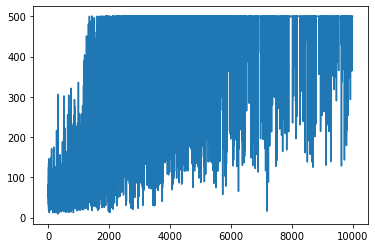

In [0]:
plt.plot(returns)